In [1]:
import pandas as pd
import numpy as np
import pickle
import codecs
import time
from itertools import chain
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from gensim.models import word2vec
from gensim.models import FastText
from gensim.test.utils import get_tmpfile

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import sys
sys.path.append("util")
from util.load_data import load_word2vec

import tensorflow as tf
from tensorflow import keras

# 1. 감정 댓글 불러오기

In [2]:
word2vec_path = "dataset/embedding/0710 w2v_model"
data_path = 'dataset/final_data/0710 comment_with_emo_over0.5.pkl'

In [3]:
emotion_comment_df = pd.read_pickle(data_path)
    
print("emotion_comment_df: ", emotion_comment_df.shape)
display(emotion_comment_df.sample(5))

emotion_comment_df:  (408607, 11)


,happy,sad,disgust,angry,surprised,fear,comment_id,comment,comment_token,check,emotion
1238681,0.0,0.0,0.333333,0.666667,0.0,0.0,879865752DFF46EA875B6A633D3A301A,싫음말지 출세동앗줄이라고 잡아놓고 어디 정권탓하고있냐 저런검사놈들 땜에 죽은 사람...,"[싫다, 말, 출세, 앗줄, 잡다, 어디, 정권, 탓, 있다, 검사, 놈, 땜, 죽...","[싫다, 싫다, 놈]",angry
1038828,0.0,0.0,0.000000,1.000000,0.0,0.0,D70F32C0ADF9444098426E63D0BDF8D3,재활용도 못하겠다! 썩어빠진년놈들 사진 실려서,"[재활용, 썩다, 빠지다, 년놈, 사진, 실리다]",[썩다],angry
1439621,0.0,0.0,0.000000,1.000000,0.0,0.0,85C7864BF18647B2AD7BCCFB320E493C,별 미친,"[별, 미치다]",[미치다],angry
985622,0.0,0.0,0.000000,1.000000,0.0,0.0,9FE0CE98B01B4DC58720EB1F0A4A78B0,죄도 없는 대통령을 감옥에 집어넣고 죄를 뒤집어 씌우기 위해 없는 죄를 만들어 낼...,"[죄, 없다, 대통령, 감옥, 집어넣다, 죄, 뒤지다, 씌우다, 위해, 없다, 죄,...","[놈, 나쁘다, 놈, 나쁘다, 놈]",angry
285755,0.0,0.0,0.000000,0.000000,1.0,0.0,2950ECE6FE5046AF99FB716DC6BAC0BE,.이것이 우리의 정확한 위치다.... 언젠가부터 우리는 우리 스스로를 선진국이...,"[우리, 정확하다, 위치, 언젠가, 부터, 우리, 우리, 스스로, 선진국, 부르다,...",[경악],surprised


In [4]:
print("샘플링 전 :",Counter(emotion_comment_df.emotion))
print()

# 각 감정별로 셔플한 다음 8,000개씩 부여 (Train = 85% / Test = 15%)
sample_count = 8000

sampled_emo_cmt_df = (
    emotion_comment_df.groupby('emotion').apply(
        lambda d: shuffle(d, random_state=42, n_samples=sample_count)).reset_index(drop=True)
)

print("샘플링 이후 :",Counter(sampled_emo_cmt_df.emotion))

샘플링 전 : Counter({'angry': 240971, 'sad': 83041, 'happy': 44682, 'disgust': 17263, 'fear': 14649, 'surprised': 8001})

샘플링 이후 : Counter({'angry': 8000, 'disgust': 8000, 'fear': 8000, 'happy': 8000, 'sad': 8000, 'surprised': 8000})


**균등한 데이터셋 분포를 위해 사전에 감정 별 데이터 크기를 동일하게 맞춤**

# 2. Text Encoding

- 모든 단어를 정수로 인코딩
- 케라스의 `Tokenizer` 클래스 사용
- 모든 단어를 각기 다른 단어 ID에 매핑. ID는 1부터 시작해 고유한 단어 개수까지 생성 (**마스킹에 사용하기 때문에 0부터 시작하지 않음**)

In [5]:
emotion_token_list = sampled_emo_cmt_df["comment_token"].tolist()


# 모든 글자를 정수 ID로 인코딩
def word_to_id(token_list):
    print("sample data : ",token_list[0])
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(token_list)
    print("texts to sequences ===>",tokenizer.texts_to_sequences([token_list[0]]))
    print("sequences to texts ===>",tokenizer.sequences_to_texts([[1,2,3,4,5]])) 
    print()
    
    word_to_id = tokenizer.word_index
    id_to_word = tokenizer.index_word
    
    print("고유 단어 개수 : {}, 전체 댓글 개수 : {}".format(len(word_to_id), tokenizer.document_count))
    
    encoded_tokens = []
    for token in token_list:
        encoded_tokens.append(tokenizer.texts_to_sequences([token])[0])
    
    return encoded_tokens, word_to_id, id_to_word
    
encoded_tokens, word_to_id, id_to_word = word_to_id(emotion_token_list)

sample data :  ['멀다', '놈', '기사', '도통', '내용', '뭐', '알다', '없다']
texts to sequences ===> [[449, 18, 52, 8897, 729, 35, 28, 3]]
sequences to texts ===> ['있다 되다 없다 보다 아니다']

고유 단어 개수 : 35670, 전체 댓글 개수 : 48000


In [6]:
# X (padding)

MAX_SEQUENCE_LENGTH = 20

data = tf.keras.preprocessing.sequence.pad_sequences(encoded_tokens, maxlen=MAX_SEQUENCE_LENGTH)

# y (one-hot encoding labels)

cat_encoder = OneHotEncoder()
labels = cat_encoder.fit_transform(sampled_emo_cmt_df[['emotion']]).toarray()

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print()
print(cat_encoder.categories_)
print(labels)

Shape of data tensor: (48000, 20)
Shape of label tensor: (48000, 6)

[array(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprised'],
      dtype=object)]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


# 3.Embedding Matrix 만들기 

In [7]:
w2v_model = load_word2vec(word2vec_path)

word2vec 모델 불러오기 ... finished in 0.58 sec.
#words = 168620, vector size = 300


In [8]:
# with pretrained model
def create_embedding_matrix(w2v_model, word_to_id):
    '''
    pretrained model이 존재할 때 embedding matrix 만드는법
    if 존재하지 않는다면, tf.keras.Embedding layer 사용
    '''
    
    EMBEDDING_DIM = w2v_model.vector_size

    embedding_matrix = np.zeros((len(word_to_id)+1, EMBEDDING_DIM))
    print(embedding_matrix.shape)

    for word, i in word_to_id.items():
        try:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
            
    return embedding_matrix

In [9]:
embedding_matrix = create_embedding_matrix(w2v_model, word_to_id)
embedding_matrix

(35671, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13877146, -0.03067526, -0.07808419, ..., -0.05337833,
        -0.0992438 , -0.00218738],
       [-0.03504737, -0.12057228,  0.01615535, ...,  0.005222  ,
        -0.08698165,  0.06102141],
       ...,
       [ 0.04774499,  0.08327273,  0.00324909, ..., -0.05244453,
        -0.05709571, -0.09028624],
       [-0.05991533, -0.03845508, -0.01238701, ..., -0.00123169,
        -0.07324471, -0.04061742],
       [-0.11260591, -0.00158114,  0.01082337, ...,  0.00661842,
        -0.05145192, -0.09587358]])

In [10]:
# shuffle data 

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# split the data into a training set and a validation set 
split_frac=0.8
split_idx = int(len(data)*split_frac)
X_train, remaining_x = data[:split_idx], data[split_idx:]
y_train, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
X_val, X_test = remaining_x[:test_idx], remaining_x[test_idx:]
y_val, y_test = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(X_train.shape), 
      "\nValidation set: \t{}".format(X_val.shape),
      "\nTest set: \t\t{}".format(X_test.shape))

			Feature Shapes:
Train set: 		(38400, 20) 
Validation set: 	(4800, 20) 
Test set: 		(4800, 20)


# 4. CNN 학습

In [11]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LEGNTH = 20
filter_sizes = [3,4,5]
num_filters = 100
dim_output = 6

class textCNN(tf.keras.Model):
    
    def __init__(self,
                 embedding_matrix,
                 output_size=dim_output,
                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                 num_filters=100,
                 filter_sizes=[3,4,5],
                 drop_prob=0.5,
                 train_embedding=False, # Note that we set trainable=False to prevent the weights from being updated during training.
                 **kwargs):
        super(textCNN,self).__init__(**kwargs) # 표준 매개변수 처리
        
        self.max_sequence_length = max_sequence_length
        self.drop_prob = drop_prob
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.output_size = output_size

        vocab_size, embedding_dim = embedding_matrix.shape
        
        #### layers
        # if using pretrained model to initialize
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    EMBEDDING_DIM,
                                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                    trainable=train_embedding) 

        # # if not using pretrained model
        # self.embedding_layer = tf.keras.layers.Embedding(len(word_to_id) + 1,
        #                                               EMBEDDING_DIM,
        #                                               input_length=MAX_SEQUENCE_LENGTH) 

        self.conv_layers = []
        for i,filter_size in enumerate(filter_sizes):
            conv_block = tf.keras.Sequential()

            conv = tf.keras.layers.Conv2D(num_filters,
                                       (filter_size, embedding_dim),
                                       padding='VALID', # ignore padding
                                       activation='relu',
                                       strides=(1,1),
                                       name=f'conv_layer_{i}')

            pooling = tf.keras.layers.MaxPooling2D((max_sequence_length - filter_size + 1, 1),
                                                padding='valid',
                                                strides=(1,1),
                                                name=f'pooling_layer_{i}')    

            conv_block.add(conv)
            conv_block.add(pooling)
            
            self.conv_layers.append(conv_block)
            
        self.dense = tf.keras.layers.Dense(output_size,
                                     activation='softmax',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                     name='prediction')
        
        self.flatten = tf.keras.layers.Flatten(name='flatten')
        self.reshape = tf.keras.layers.Reshape((max_sequence_length, embedding_dim, 1))
        self.dropout = tf.keras.layers.Dropout(rate=drop_prob, name='dropout')
        
    def call(self, inputs, training=None):
        
        embedding = self.embedding_layer(inputs)
        reshape = self.reshape(embedding) #(sequence_length,EMBEDDING_DIM,1)
        
        pool_outputs = [layer(reshape) for layer in self.conv_layers]
        pool_outputs = tf.keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
        pool_outputs = self.flatten(pool_outputs)
        pool_outputs = self.dropout(pool_outputs)

        if training:
            pool_outputs=self.dropout(pool_outputs)

        logit = self.dense(pool_outputs)
        
        return logit

In [12]:
cnn = textCNN(embedding_matrix = embedding_matrix,
              max_sequence_length=20,
              output_size = 6)

In [13]:
cnn.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30)]

In [19]:
 # starts training
history = cnn.fit(X_train, y_train,
                  batch_size=32, 
                  epochs=200, 
                  verbose=1,
                  validation_data=(X_val,y_val),
                  callbacks=callbacks) 

Epoch 1/200
1200/1200 [==============================] - 10s 8ms/step - loss: 0.4104 - acc: 0.8992 - val_loss: 0.3599 - val_acc: 0.9062
Epoch 2/200
1200/1200 [==============================] - 10s 8ms/step - loss: 0.3828 - acc: 0.9066 - val_loss: 0.3440 - val_acc: 0.9110
Epoch 3/200
1200/1200 [==============================] - 9s 8ms/step - loss: 0.3619 - acc: 0.9119 - val_loss: 0.3319 - val_acc: 0.9123
Epoch 4/200
1200/1200 [==============================] - 10s 8ms/step - loss: 0.3437 - acc: 0.9167 - val_loss: 0.3249 - val_acc: 0.9121
Epoch 5/200
1200/1200 [==============================] - 10s 8ms/step - loss: 0.3296 - acc: 0.9198 - val_loss: 0.3201 - val_acc: 0.9135
Epoch 6/200
1200/1200 [==============================] - 9s 8ms/step - loss: 0.3192 - acc: 0.9241 - val_loss: 0.3147 - val_acc: 0.9135
Epoch 7/200
1200/1200 [==============================] - 9s 8ms/step - loss: 0.3094 - acc: 0.9273 - val_loss: 0.3073 - val_acc: 0.9162
Epoch 8/200
1200/1200 [============================

In [20]:
cnn.summary()

Model: "text_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  10701300  
_________________________________________________________________
sequential (Sequential)      (32, 1, 1, 100)           90100     
_________________________________________________________________
sequential_1 (Sequential)    (32, 1, 1, 100)           120100    
_________________________________________________________________
sequential_2 (Sequential)    (32, 1, 1, 100)           150100    
_________________________________________________________________
prediction (Dense)           multiple                  1806      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0  

# 5. Result

In [21]:
# final evaluation of the model
print ("")
scores = cnn.evaluate(X_test, y_test, verbose=1)
print ("")
print ("loss: %.2f%%" % (scores[0] * 100))
print ("Accuracy: %.2f%%" % (scores[1] * 100))


150/150 [==============================] - 0s 3ms/step - loss: 0.3082 - acc: 0.9112

loss: 30.82%
Accuracy: 91.12%


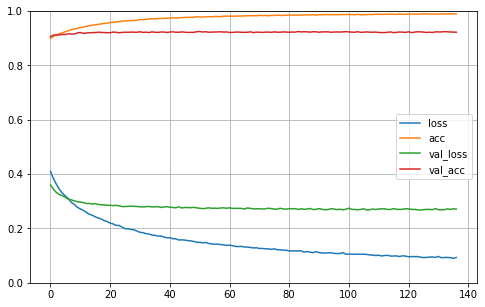

In [28]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.savefig('savefig_500dpi.png', dpi=500)

In [23]:
y_proba = cnn.predict(X_test)
print("probability")
print(y_proba.round(2))


class_names = cat_encoder.categories_[0]
y_pred = np.argmax(y_proba,axis=1)
print()
print("predict")
print(class_names[y_pred])
print()
print("감정 개수 별 예측")
print(Counter(class_names[y_pred]))

probability
[[0.   0.   0.   0.   1.   0.  ]
 [1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 ...
 [0.13 0.04 0.02 0.02 0.78 0.01]
 [0.99 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]

predict
['sad' 'angry' 'fear' ... 'sad' 'angry' 'surprised']

감정 개수 별 예측
Counter({'sad': 857, 'happy': 844, 'angry': 819, 'surprised': 787, 'fear': 764, 'disgust': 729})


---

# Alpha
## 함수형 API

In [91]:
vocab_size, embedding_dim = embedding_matrix.shape


# functional
sequence_length = X_train.shape[1]
inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM,
                                   weights=[embedding_matrix],
                                   trainable=True)(inputs)
reshape = tf.keras.layers.Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = tf.keras.layers.Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(reshape)
conv_1 = tf.keras.layers.Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(reshape)
conv_2 = tf.keras.layers.Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(reshape)

maxpool_0 = tf.keras.layers.MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), 
                                      strides=(1,1))(conv_0)
maxpool_1 = tf.keras.layers.MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), 
                                      strides=(1,1))(conv_1)
maxpool_2 = tf.keras.layers.MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), 
                                      strides=(1,1))(conv_2)

# pool_outputs = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
pool_outputs = tf.keras.layers.Concatenate()([maxpool_0, maxpool_1, maxpool_2])

flatten = tf.keras.layers.Flatten()(pool_outputs)
dropout = tf.keras.layers.Dropout(drop_prob)(flatten)
output = Dense(units=6, 
               activation='softmax',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = tf.keras.Model(inputs, output)

# 2018ver

In [30]:
def cnn_model(dropout):   
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv2 = Sequential()        

        EMBEDDING_DIM = 300
        MAX_SEQUENCE_LENGTH = 20
        
        # 3 Conv1D layers
        model_Conv2.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(GlobalMaxPooling1D())
        
        model_Conv2.add(Dense(256, activation='relu'))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Dense(64, activation='relu'))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(Dense(6, activation='softmax'))
        
        # optimizer 사용
        Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
        
        model_Conv2.compile(
            loss = 'categorical_crossentropy',
            optimizer = Adam,
            metrics = ['accuracy'])
        
        model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = tf.keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model2 = model_Conv2.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv2.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model2.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model2.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model2.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(conv_model2.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv2